In [265]:
!ls

gold_recovery_full_new.csv  gold_recovery_train_new.csv
gold_recovery_test_new.csv  ntb.ipynb


# 1. Подготовьте данные
## 1.1. Откройте файлы и изучите их.

In [266]:
import pandas as pd 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt 
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,7)


In [422]:
train_df = pd.read_csv('gold_recovery_train_new.csv')
test_df = pd.read_csv('gold_recovery_test_new.csv')
full_df = pd.read_csv('gold_recovery_full_new.csv')

In [268]:
dfs = [train_df, test_df, full_df]

## 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [269]:
train_df['rougher.output.recovery'] #то что перепроверям 

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [270]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [271]:
#display(train_df.iloc[:, 30:65].head())
display(train_df.iloc[:, 30:65].columns)

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floa

сначала нужно посчитть это: 

- C — доля золота в концентрате после флотации/очистки; (+) (rougher.output.feed_au_share)
- F — доля золота в сырье/концентрате до флотации/очистки; (+) (rougher.input.feed_au_share)
- T — доля золота в отвальных хвостах после флотации/очистки.

In [272]:
 #rougher.output.concentrate_au - rougher.input.feed_au - rougher.output.tail_au
train_df[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']]

C = train_df['rougher.output.concentrate_au']
F = train_df['rougher.input.feed_au']
T = train_df['rougher.output.tail_au']

train_df['recovery_test'] = (C*(F-T))/(F*(C-T))*100


In [273]:
#появились наны из-за нулей в rougher.output.concentrate_so
train_df[train_df['recovery_test'].isnull()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery_test


In [274]:
#посмотрим что без нанов 
print(mean_absolute_error(train_df.dropna(subset=['recovery_test'])['rougher.output.recovery'], 
                            train_df.dropna(subset=['recovery_test'])['recovery_test']))

9.73512347450521e-15


## 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [275]:
test_df.isnull().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

In [276]:
print('columns in train', len(train_df.columns))
print('columns in test', len(test_df.columns))

print(len(set(train_df.columns).difference(set(test_df.columns))))
train_test_dif_cols = set(train_df.columns).difference(set(test_df.columns))

columns in train 88
columns in test 53
35


In [277]:
from pprint import pprint 
pprint(train_test_dif_cols)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery_test',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 

## 1.4. Проведите предобработку данных.

Что можно сделать в предобработке: 

1. удалить из train колонки, которые недоступны в test (позже)
2. Удалить пропуски, если их немного 
3. сбросить дубликаты 

In [278]:
cols = test_df.columns

for df in dfs: 
    #проверка на дубликаты 
    print(len(df.columns))
    #тут пока непонятно, стоит ли до EDA удалять колонки 
    #df = df[cols]
    print(len(df.columns))
    print(df.shape)
    print(df.duplicated().sum())
    print(df.isnull().sum().sort_values(ascending=False))
    

88
88
(14149, 88)
0
secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
final.output.tail_pb                                   100
rougher.input.feed_pb                                  100
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol      

# 2. Проанализируйте данные


## 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы. (на обучающей выборке)

In [279]:
#словарь столбцов с инпутом и аутпутом в этапах, чтобы проще было ковыряться в этом безобразии
l_cols = {}

for l in ['rougher', 'primary_cleaner',
           'secondary_cleaner', 'final']:
    
    l_cols[l] = {}
    l_cols[l]['input'] = []
    l_cols[l]['output'] = []

    print(l)
    
    for col in full_df.columns:

        if l == col.split('.')[0] and col.split('.')[1] == 'input':
            l_cols[l]['input'].append(col)
        elif l == col.split('.')[0] and col.split('.')[1] == 'output':
            l_cols[l]['output'].append(col)
        else:
            continue

rougher
primary_cleaner
secondary_cleaner
final


### rougher

In [280]:
l_cols['rougher']['output']

['rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au']

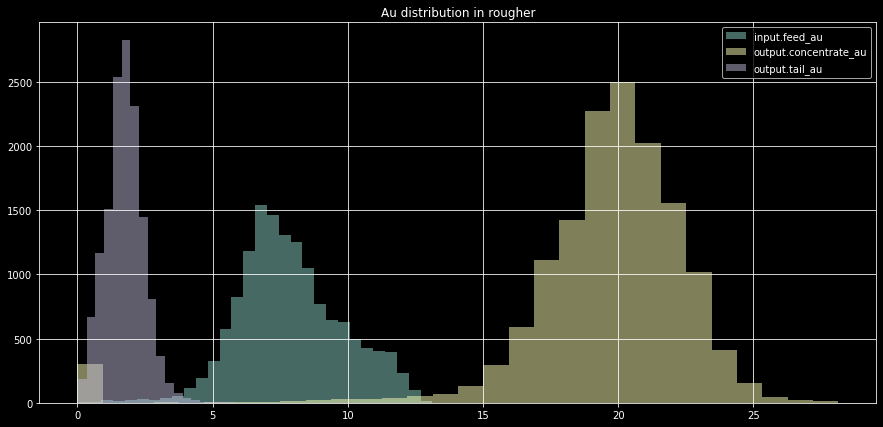

In [281]:
train_df['rougher.input.feed_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_au'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Au distribution in rougher')
plt.legend(['input.feed_au', 'output.concentrate_au', 'output.tail_au'])
plt.show()

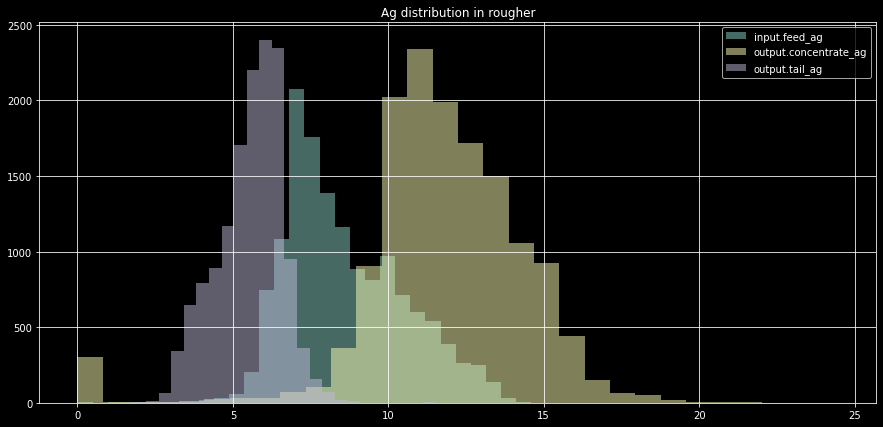

In [282]:
train_df['rougher.input.feed_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_ag'].hist(alpha = 0.5, bins =30)
plt.title('Ag distribution in rougher')
plt.legend(['input.feed_ag', 'output.concentrate_ag', 'output.tail_ag'])
plt.show()

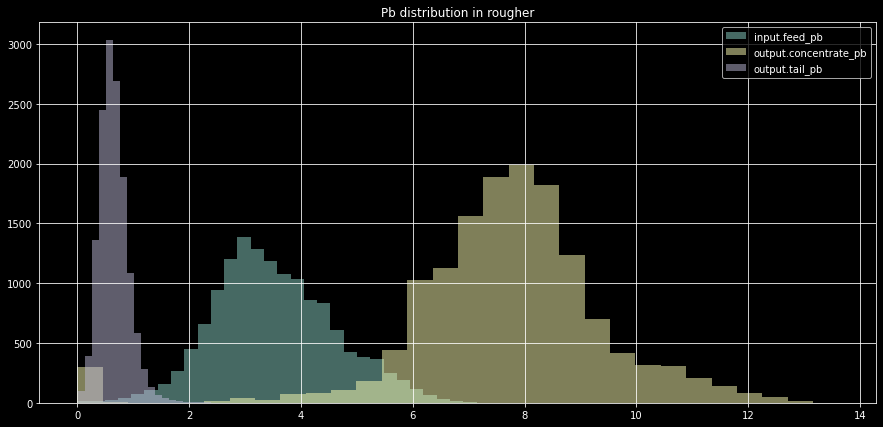

In [283]:
train_df['rougher.input.feed_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['rougher.output.tail_pb'].hist(alpha = 0.5, bins =30)
plt.title('Pb distribution in rougher')
plt.legend(['input.feed_pb', 'output.concentrate_pb', 'output.tail_pb'])
plt.show()

Получается, что даже первый этап грубой очистки уже справляется со своей работой. 

Особенно хорошо он справляется с золотом и свинцом, хуже справляется с серебром при этом. 

### primary_cleaner

In [284]:
l_cols['primary_cleaner']

{'input': ['primary_cleaner.input.sulfate',
  'primary_cleaner.input.depressant',
  'primary_cleaner.input.feed_size',
  'primary_cleaner.input.xanthate'],
 'output': ['primary_cleaner.output.concentrate_ag',
  'primary_cleaner.output.concentrate_pb',
  'primary_cleaner.output.concentrate_sol',
  'primary_cleaner.output.concentrate_au',
  'primary_cleaner.output.tail_ag',
  'primary_cleaner.output.tail_pb',
  'primary_cleaner.output.tail_sol',
  'primary_cleaner.output.tail_au']}

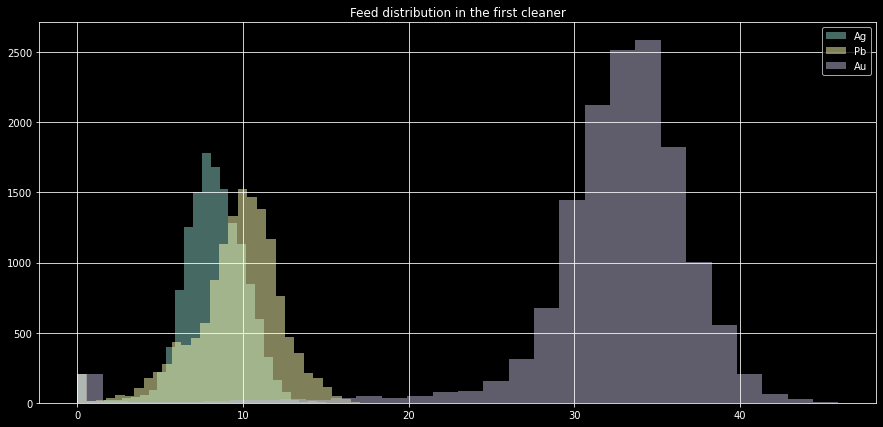

In [285]:
#сравним что получилось после первого этапа чистки по металлам 
train_df['primary_cleaner.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['primary_cleaner.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the first cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

Видно, что на этом этапе очень сильно удается выделить из входящей массы серебро

### secondary cleaner

In [286]:
l_cols['secondary_cleaner']

{'input': [],
 'output': ['secondary_cleaner.output.tail_ag',
  'secondary_cleaner.output.tail_pb',
  'secondary_cleaner.output.tail_sol',
  'secondary_cleaner.output.tail_au']}

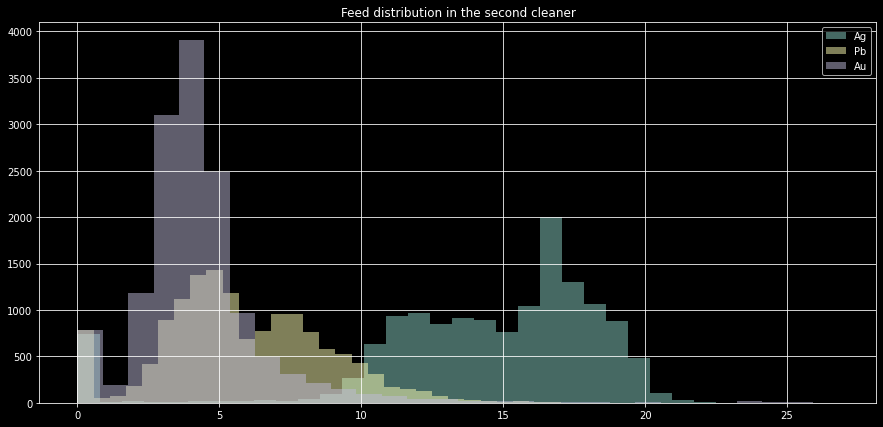

In [287]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['secondary_cleaner.output.tail_ag'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_pb'].hist(alpha = 0.5, bins = 30)
train_df['secondary_cleaner.output.tail_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution in the second cleaner')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на вторичном этапе очистки довольно большой % серебра уходит в остатки, меньше всего в остатки уходит золото

### final

In [288]:
l_cols['final']

{'input': [],
 'output': ['final.output.concentrate_ag',
  'final.output.concentrate_pb',
  'final.output.concentrate_sol',
  'final.output.concentrate_au',
  'final.output.recovery',
  'final.output.tail_ag',
  'final.output.tail_pb',
  'final.output.tail_sol',
  'final.output.tail_au']}

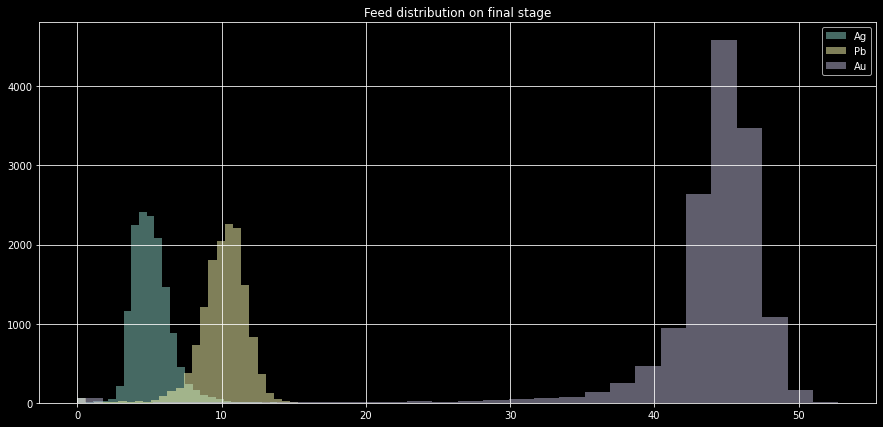

In [289]:
#сравним что получилось после второго этапа чистки по металлам 
train_df['final.output.concentrate_ag'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_pb'].hist(alpha = 0.5, bins = 30)
train_df['final.output.concentrate_au'].hist(alpha = 0.5, bins =30)
plt.title('Feed distribution on final stage')
plt.legend(['Ag', 'Pb', 'Au'])
plt.show()

на финальном этапе вообще красота, % золота очень сильно подросла и колеблется в основном от 40% до 50%. 

будем считать, что система очистки справляется со своей работой 

## 2.2 Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.  Если распределения сильно отличаются друг от друга, оценка модели будет  неправильной

In [290]:
#посмотрим какие колонки у нас есть в тестовой 
[col for col in test_df.columns if col.split('.')[-1]=='feed_size']

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [291]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1]=='feed_size']

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

сравнить мы можем две одинаковые стадии между собой: отдельно rougher и первичный клинер

60.11051805066844 -- средний размер гранул в трейн выборке
55.951097447596965 -- средний размер гранул в тест выборке
55.37388507888542 -- медиана гранул в трейн выборке
50.841029192879 -- медиана размер гранул в тест выборке


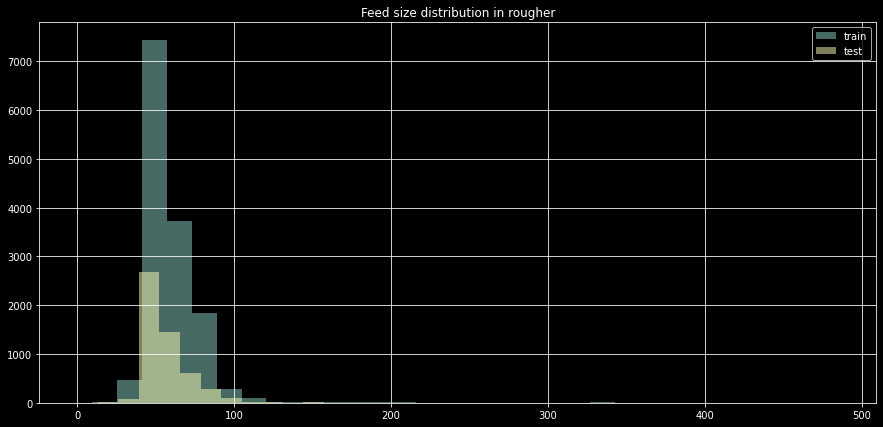

In [292]:
#сравним что получилось после второго этапа чистки по металлам 

print(train_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')

train_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
test_df['rougher.input.feed_size'].hist(alpha = 0.5, bins = 30)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

из-за выбросов в feed_size в трейн выборке не очень приятно сравнивать распределения, посмотрим без них

58.71075089900921 -- средний размер гранул в трейн выборке
55.388305241565845 -- средний размер гранул в тест выборке
55.26017512380482 -- медиана гранул в трейн выборке
50.75667403647809 -- медиана размер гранул в тест выборке


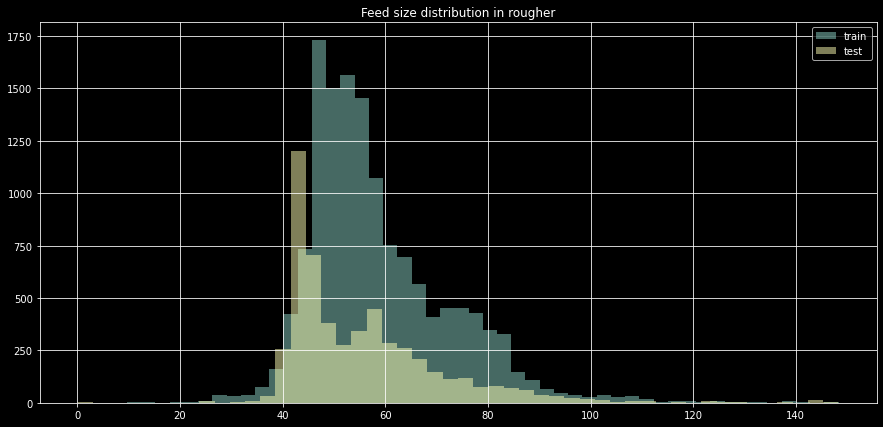

In [293]:
#сравним что получилось после второго этапа чистки по металлам, немного призумимся
print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].mean(), '-- средний размер гранул в тест выборке')

print(train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана гранул в трейн выборке')
print(test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].median(), '-- медиана размер гранул в тест выборке')


train_df[train_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
test_df[test_df['rougher.input.feed_size']<150]['rougher.input.feed_size'].hist(alpha = 0.5, bins = 50)
plt.title('Feed size distribution in rougher')
plt.legend(['train', 'test'])
plt.show()

Распределение отличаюются, но все же скорее похожи друг на друга (оба смещены скорее влево). При этом надо отметить, что периодически залетают булыжники в массу сырья

## 2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях:  в сырье, в черновом и финальном концентратах

In [294]:
#а какие в обучающей 
[col for col in train_df.columns if col.split('.')[-1].split('_')[0]=='concentrate']

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

### rougher

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,total_conc
0,11.500771,7.101074,28.029297,19.793808,66.424950
1,11.615865,7.278807,28.067063,20.050975,67.012710
2,11.695753,7.216833,27.454037,19.737170,66.103793
3,11.915047,7.175616,27.341277,19.320810,65.752751
4,12.411054,7.240205,27.041023,19.216101,65.908382


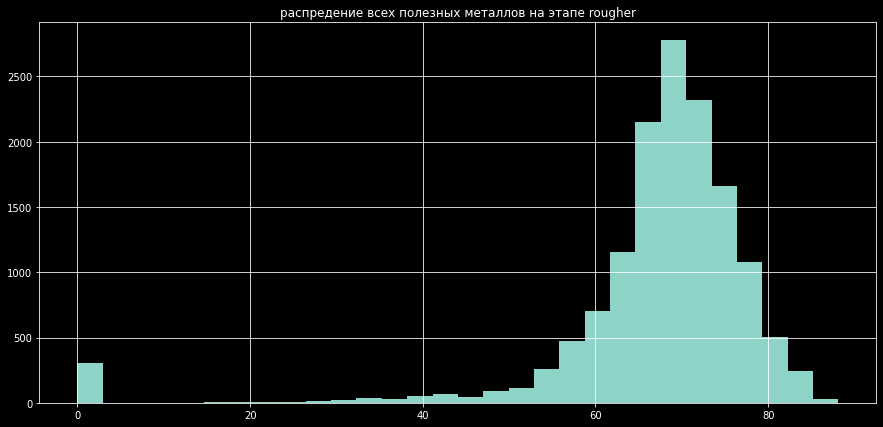

In [295]:
rougher_conc_df = train_df[['rougher.output.concentrate_ag',
                            'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol',
                            'rougher.output.concentrate_au']].copy()

rougher_conc_df['total_conc'] = rougher_conc_df.sum(axis=1)
display(rougher_conc_df.head())

rougher_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе rougher')
plt.show()

### primary_cleaner

,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,total_conc
0,8.547551,10.389648,19.529297,34.174427,72.640924
1,8.558743,10.497069,19.369147,34.118526,72.543485
2,8.603505,10.354494,19.167579,33.969464,72.095042
3,7.221879,8.496563,15.978538,28.260743,59.957723
4,9.089428,9.986786,19.199864,33.044932,71.321010


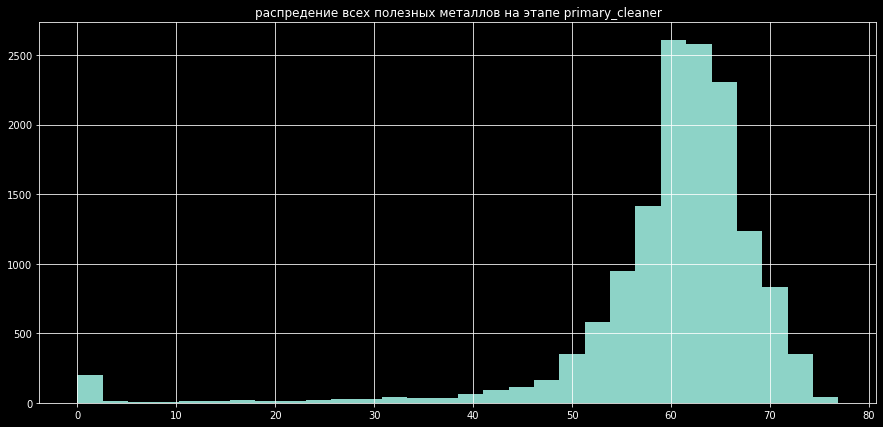

In [296]:
primary_cleaner_conc_df = train_df[['primary_cleaner.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.concentrate_au']].copy()

primary_cleaner_conc_df['total_conc'] = primary_cleaner_conc_df.sum(axis=1)
display(primary_cleaner_conc_df.head())

primary_cleaner_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе primary_cleaner')
plt.show()

### secondary cleaner

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,total_conc
0,6.055403,9.889648,5.507324,42.192020,63.644396
1,6.029369,9.968944,5.257781,42.701629,63.957723
2,6.055926,10.213995,5.383759,42.657501,64.311180
3,6.047977,9.977019,4.858634,42.689819,63.573449
4,6.148599,10.142511,4.939416,42.774141,64.004667


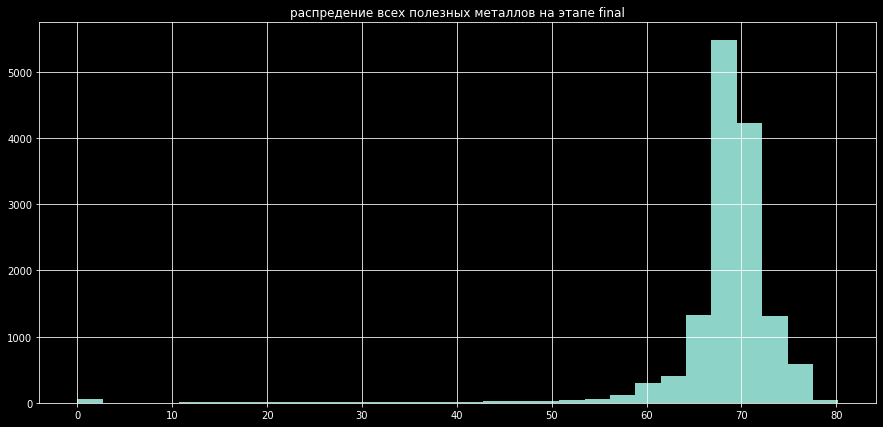

In [297]:
final_conc_df = train_df[['final.output.concentrate_ag',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
                            'final.output.concentrate_au']].copy()

final_conc_df['total_conc'] = final_conc_df.sum(axis=1)
display(final_conc_df.head())

final_conc_df['total_conc'].hist(bins = 30)
plt.title('распредение всех полезных металлов на этапе final')
plt.show()

### total

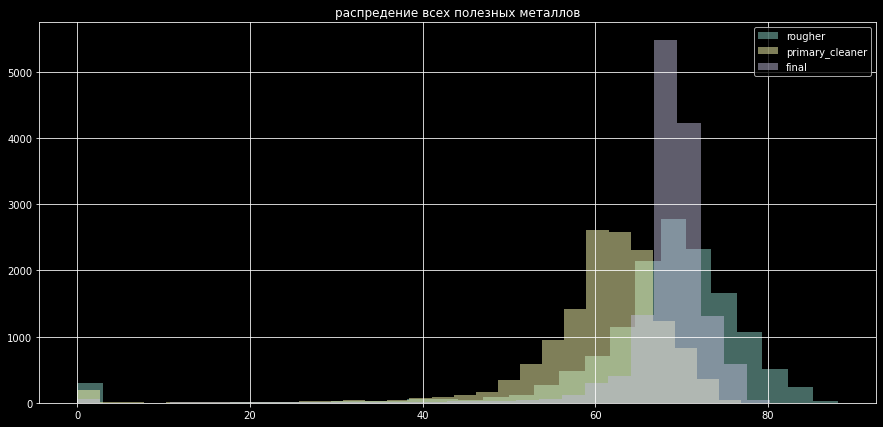

In [298]:
rougher_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
primary_cleaner_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
final_conc_df['total_conc'].hist(bins = 30, alpha = 0.5)
plt.legend(['rougher', 'primary_cleaner', 'final'])
plt.title('распредение всех полезных металлов')
plt.show()

# Modeling

1. сначала подготовить тестовые и обучающие выборки: 
    - избавиться от пропусков (выкинуть, если не слишком много)
    - подумать над выбросами в основных показателях 
    - в обеих выборках должны быть только те колонки, что есть в тестовой 

2. взять несколько моделей: 
    - linear regression + lasso + ridge 
    - random forest regressor 
    - catboost из короки

3. обучить каждую из моделей на трейн датасете с помощью кросс-валидации и вывести показания метрики 

In [343]:
def smape(target, pred): 
    smape = np.mean(abs(target-pred)/((abs(target)+abs(pred))/2)*100)
    return smape


In [359]:
import catboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns

In [429]:
train_df = pd.read_csv('gold_recovery_train_new.csv')

In [430]:
train_df.isnull().sum().sort_values(ascending=False)
train_df = train_df.dropna()
train_df.set_index('date', inplace=True)

In [431]:
first_target_train = train_df['rougher.output.recovery']
second_target_train = train_df['final.output.recovery']

In [432]:
first_target_train

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 11017, dtype: float64

In [433]:
sns.heatmap(train_df.join(first_target_train).corr())

ValueError: columns overlap but no suffix specified: Index(['rougher.output.recovery'], dtype='object')

In [435]:
train_df = train_df[test_df.set_index('date').columns]

In [436]:
#train_df.set_index('date', inplace = True)
features = list(train_df.columns)

In [437]:
#обычная линейная модель 

model = LinearRegression()

x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(smape(y_val, pred))
print(mean_absolute_error(y_val, pred))

9.362801311983828
5.757455133075844


In [386]:
model = catboost.CatBoostRegressor()

x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(smape(y_val, pred))

Learning rate set to 0.057744
0:	learn: 13.2250133	total: 5.3ms	remaining: 5.29s
1:	learn: 12.9764491	total: 9.29ms	remaining: 4.63s
2:	learn: 12.7071223	total: 13.3ms	remaining: 4.43s
3:	learn: 12.4585171	total: 17.9ms	remaining: 4.46s
4:	learn: 12.2532156	total: 22.6ms	remaining: 4.5s
5:	learn: 12.0600878	total: 26.9ms	remaining: 4.45s
6:	learn: 11.8879749	total: 30.3ms	remaining: 4.29s
7:	learn: 11.7290918	total: 34ms	remaining: 4.21s
8:	learn: 11.5704099	total: 37ms	remaining: 4.07s
9:	learn: 11.4315506	total: 40.8ms	remaining: 4.04s
10:	learn: 11.3115421	total: 44.6ms	remaining: 4.01s
11:	learn: 11.1813174	total: 48.6ms	remaining: 4s
12:	learn: 11.0658646	total: 52.4ms	remaining: 3.97s
13:	learn: 10.9693895	total: 56.1ms	remaining: 3.95s
14:	learn: 10.8804835	total: 59.4ms	remaining: 3.9s
15:	learn: 10.7618756	total: 63ms	remaining: 3.87s
16:	learn: 10.6685586	total: 66.1ms	remaining: 3.82s
17:	learn: 10.5963524	total: 69.4ms	remaining: 3.79s
18:	learn: 10.5360109	total: 73ms	rema

In [387]:
for depth in range(1,9):
    for est in range(1,50,10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=42)

        x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
        model.fit(x_train, y_train)
        pred = model.predict(x_val)

        print(smape(y_val, pred))

11.349228702301836
11.42117555102067
11.43007569840832
11.42418122752838
11.41795145552828
10.745612374656138
10.152204673313447
10.159349547076811
10.173042326879713
10.100407595009568
9.888601582047398
9.377381526031066
9.399263981121843
9.399898621347276
9.339114824669013
9.49123204035412
9.160732910382414
9.184843095091246
9.159068230571597
9.164744852239494
8.771468690892483
8.938512035543097
8.988627373689463
8.998956109417403
8.986166764559032
8.549839234775874
8.837573789586594
8.796964680614309
8.795349016443279
8.803044792500254
7.564867553507162
8.636069889395056
8.59465657190069
8.601414333847753
8.621275608335731
7.8790280364260985
8.083038545163978
8.14731506866122
8.241079191636468
8.270799221569376


In [438]:
#почистим выбросы 
def df_clean(df_reg, features):
    for col in df_reg[features].columns:
        lower = np.percentile(df_reg[col], 1)
        upper = np.percentile(df_reg[col], 99)        
        df_reg = df_reg[(df_reg[col]> lower) & (df_reg[col]<upper)]
        return df_reg 

In [439]:
train_df = train_df.join(first_target_train).join(second_target_train)

train_df = df_clean(train_df, features)

In [440]:
first_target_train = train_df['rougher.output.recovery']
second_target_train = train_df['final.output.recovery']

train_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1, inplace = True)

In [441]:
#обычная линейная модель 

model = LinearRegression()

x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(smape(y_val, pred))
print(mean_absolute_error(y_val, pred))

8.684647150446118
5.372312373410866


In [442]:
for depth in range(1,9):
    for est in range(1,50,10):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=42)

        x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
        model.fit(x_train, y_train)
        pred = model.predict(x_val)

        print(smape(y_val, pred))

10.824890917977317
10.828659552837703
10.820278898078982
10.815834541102477
10.812298044284566
9.441894001430885
9.202864529208261
9.202488943220066
9.219892654816968
9.179741444710624
9.185037469199553
8.53081075237192
8.506028841349206
8.488990160167006
8.487418032305097
9.287688306677195
8.331814217905722
8.28281101950092
8.310386554392185
8.274947996957827
9.101169736734413
8.096804060129863
8.033925998897963
8.055513205230225
8.039701157091486
8.52223550025459
7.8853731494624935
7.808543607804594
7.8441443803223905
7.8336528776858225
8.83957210070338
7.7239681435105325
7.626009189998632
7.644390813324453
7.634032514849077
8.678481883493296
7.631921907924368
7.498902282464394
7.5287834553209985
7.504172848721562


In [443]:
model = catboost.CatBoostRegressor()

x_train, x_val, y_train, y_val = train_test_split(train_df, first_target_train, test_size=0.2, random_state=42)
model.fit(x_train, y_train)
pred = model.predict(x_val)

print(smape(y_val, pred))

Learning rate set to 0.057559
0:	learn: 13.3118408	total: 4.02ms	remaining: 4.02s
1:	learn: 13.1075261	total: 10.3ms	remaining: 5.16s
2:	learn: 12.8576696	total: 13.9ms	remaining: 4.63s
3:	learn: 12.6248131	total: 17.1ms	remaining: 4.26s
4:	learn: 12.4328552	total: 20.2ms	remaining: 4.02s
5:	learn: 12.2457192	total: 23.3ms	remaining: 3.85s
6:	learn: 12.0875599	total: 26.3ms	remaining: 3.73s
7:	learn: 11.9224580	total: 29.2ms	remaining: 3.62s
8:	learn: 11.7745124	total: 32.5ms	remaining: 3.58s
9:	learn: 11.6408770	total: 36.1ms	remaining: 3.57s
10:	learn: 11.5199582	total: 39.1ms	remaining: 3.51s
11:	learn: 11.3736233	total: 42.1ms	remaining: 3.47s
12:	learn: 11.2500007	total: 45ms	remaining: 3.42s
13:	learn: 11.1465439	total: 48.1ms	remaining: 3.39s
14:	learn: 11.0623298	total: 50.9ms	remaining: 3.34s
15:	learn: 10.9429496	total: 54.2ms	remaining: 3.33s
16:	learn: 10.8593635	total: 57.5ms	remaining: 3.32s
17:	learn: 10.7774167	total: 60.4ms	remaining: 3.29s
18:	learn: 10.6944018	total: